<a href="https://colab.research.google.com/github/qortmdgh4141/Comparing-the-Effect-of-Transfer-Learning-on-ResNet-for-Classification-Problems/blob/main/TL_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**1. 패키지 설정**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# colab에서 기본적으로 제공하지 않는 라이브러리 설치
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 57.1 MB/s eta 0:00:00


In [8]:
import os
import gc
import time
import onnx
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

from PIL import Image
from PIL import ImageFile
from matplotlib.lines import Line2D

####**2. 데이터 준비**

In [ ]:
# 데이터셋 불러오기
zip_path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_korean_family_dataset_resolution_128.zip'
output_dir = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset'

if os.path.exists(output_dir):
    print("이미 파일의 압축을 해제를 수행하였습니다.")
else:
    print("파일의 압축을 해제를 수행합니다.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

이미 파일의 압축을 해제를 수행하였습니다.


In [ ]:
"""
[Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"

Training dataset: (F0001 ~ F0299) folders have 10,025 images.
Validation dataset: (F0801 ~ F0850) folders have 1,539 images.
Test dataset: (F0851 ~ F0900) folders have 1,504 images.'''
"""
def parsing(meta_data):
    image_age_list = []

    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])

    return image_age_list

In [ ]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/train_images"

val_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/val_images"

test_meta_data_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/custom_dataset/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 배치 사이즈 정의
batch_size=32

# 학습 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 검증 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 테스트 Dataset 인스턴스 생성 후, DataLoader 인스턴스 정의
test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"학습 데이터셋 개수 : {len(train_dataset)}개")
print(f"검증 데이터셋 개수 : {len(val_dataset)}개")
print(f"테스트 데이터셋 개수 : {len(test_dataset)}개")

학습 데이터셋 개수 : 10025개
검증 데이터셋 개수 : 1539개
테스트 데이터셋 개수 : 1504개


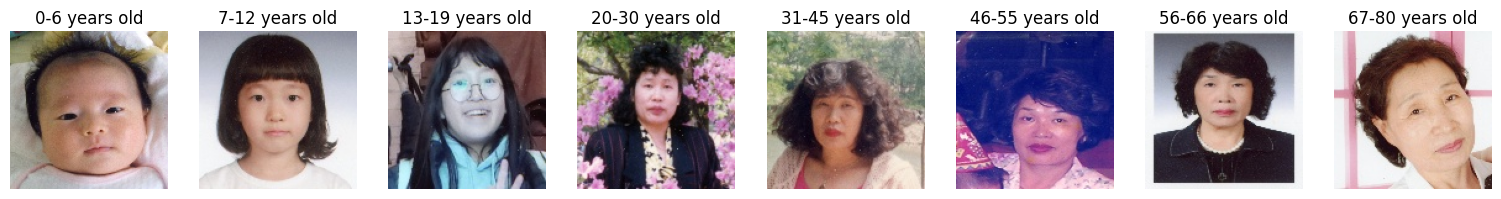

In [ ]:
# 8개의 이미지와 목표 변수(클래스)를 그래프로 출력
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

plot_count = 0
classes_seen = set()
plt.figure(figsize=(24, 4))

for i in range(len(train_dataset)):
    if plot_count == 8:
        break

    image, label = train_loader.dataset[i]
    image = np.transpose(image, (1, 2, 0))
    image = (image + 1) / 2  # -1~1 범위를 0~1 범위로 변환

    class_name = label_to_age[label]

    if class_name not in classes_seen:
        plt.subplot(1, 10, plot_count+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

        classes_seen.add(class_name)
        plot_count += 1

plt.show() # 그래프 출력

####**3. 탐색적 데이터 분석**

In [ ]:
# 입력 데이터의 차원 변환 : 3차원(이미지 수, 3, 128, 128) -> 2차원 (이미지 수, 3*128*128)
images = np.empty((len(train_dataset), 3, 128, 128), dtype=np.float32)
labels = np.empty(len(train_dataset), dtype=np.int64)

'''for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    images[i] = image
    labels[i] = label'''

x_train_reshaped = images.reshape(len(images), 128*128*3)

# 데이터 프레임으로 변형하여 널 값의 빈도 확인
x_train_df = pd.DataFrame(x_train_reshaped)
total_null_count = x_train_df.isnull().sum().sum()

print(f"널값의 개수 : {total_null_count}개")

널값의 개수 : 0개


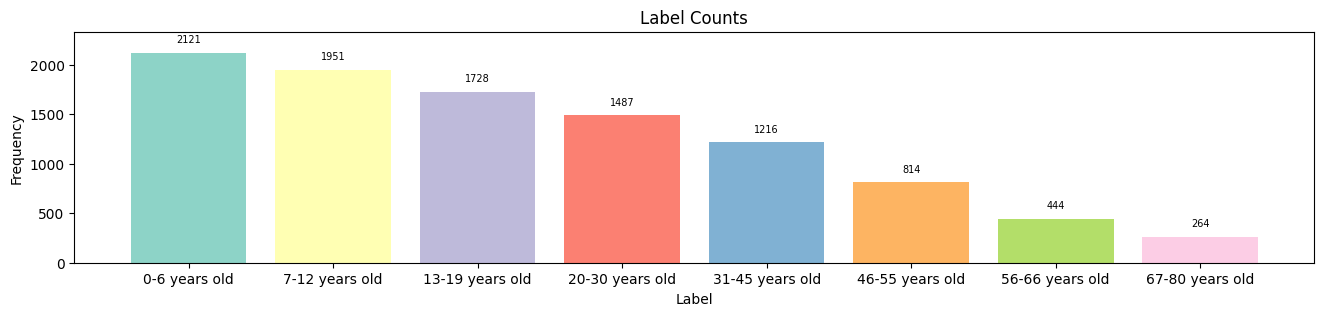

In [ ]:
# 목표변수의 라벨별 빈도 계산 후 데이터 프레임으로 변환
y_cnt = pd.DataFrame(labels).value_counts()
df = pd.DataFrame(y_cnt, columns=['Count'])

# 인덱스 리셋 및 문자열로 변환
df.reset_index(inplace=True)
df['Label'] = list(label_to_age.values())

# 컬러맵 설정 및 바차트 생성
cmap = plt.cm.Set3
fig, ax = plt.subplots(figsize=(16, 3))
bars = ax.bar(df['Label'], df['Count'], color=cmap(np.arange(len(df))))

# 바 위에 라벨 갯수 출력
for i, count in enumerate(df['Count']):
    ax.text(i, count + 100, str(count), ha='center', fontsize=7)

# 그래프 레이블과 제목 설정 및  y축 범위 늘리기 (현재 최댓값의 110%로 범위 지정)
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.set_title('Label Counts')
ax.set_ylim(0, df['Count'].max() * 1.1)

plt.show() # 그래프 출력

####**4. ResNet50 모델 아키텍처 정의**

In [ ]:
def org_resnet50():
    model = models.resnet50(pretrained=False)
    # Convolutional Xavier initialization으로 설정
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        # Batch Normalization layers의 gamma를 1로, beta를 0으로 설정
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
    return model

def pretrained_org_resnet50():
    model = models.resnet50(pretrained=True)
    return model

def bcd_resnet50():
    model = models.resnet50(pretrained=False)
    model.conv1=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    model.layer2[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    model.layer3[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    model.layer4[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    # Convolutional Xavier initialization으로 설정
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        # Batch Normalization layers의 gamma를 1로, beta를 0으로 설정
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
    return model

def pretrained_bcd_resnet50():
    model = models.resnet50(pretrained=True)
    model.conv1=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    model.layer2[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    model.layer3[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    model.layer4[0].downsample=nn.Sequential(
        nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=0),
        nn.Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
        nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    return model

#### <b> 5. Model 생성 및 "Train / Validate / Test" 함수 정의</b>

In [ ]:
log_step = 1
learning_rate = 0.01
num_features = models.resnet50(pretrained=False).fc.in_features

org_net = org_resnet50()
org_net.fc = nn.Linear(num_features, 8)
init.xavier_uniform_(org_net.fc.weight)
nn.init.constant_(org_net.fc.bias, 0)
org_net = org_net.to('cuda')
org_criterion = nn.CrossEntropyLoss()
org_optimizer = optim.Adam(org_net.parameters(), lr=learning_rate*10)
org_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(org_optimizer, T_max=10, eta_min=0)

trans_net = pretrained_org_resnet50()
trans_net.fc = nn.Linear(num_features, 8)
init.xavier_uniform_(trans_net.fc.weight)
nn.init.constant_(trans_net.fc.bias, 0)
trans_net = trans_net.to('cuda')
trans_criterion = nn.CrossEntropyLoss()
trans_optimizer = optim.Adam(trans_net.parameters(), lr=learning_rate)
trans_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(trans_optimizer, T_max=10, eta_min=0)

bcd_net = bcd_resnet50()
bcd_net.fc = nn.Linear(num_features, 8)
init.xavier_uniform_(bcd_net.fc.weight)
nn.init.constant_(bcd_net.fc.bias, 0)
bcd_net = bcd_net.to('cuda')
bcd_criterion = nn.CrossEntropyLoss()
bcd_optimizer = optim.Adam(bcd_net.parameters(), lr=learning_rate*10)
bcd_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(bcd_optimizer, T_max=10, eta_min=0)

trans_bcd_net = pretrained_bcd_resnet50()
trans_bcd_net.fc = nn.Linear(num_features, 8)
init.xavier_uniform_(trans_bcd_net.fc.weight)
nn.init.constant_(trans_bcd_net.fc.bias, 0)
trans_bcd_net = trans_bcd_net.to('cuda')
trans_bcd_criterion = nn.CrossEntropyLoss()
trans_bcd_optimizer = optim.Adam(trans_bcd_net.parameters(), lr=learning_rate)
trans_bcd_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(trans_bcd_optimizer, T_max=10, eta_min=0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache

In [ ]:
def train(net, scheduler, optimizer, criterion, epoch):
    print(f'[Epoch: {epoch + 1} - Training]')

    net.train()

    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_loader):
        imgs, labels = batch
        imgs, labels = imgs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()

        outputs = net(imgs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'\t\t[Batch: {i + 1} / {len(train_loader)}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    scheduler.step()

    return running_loss / total, (running_corrects / total).item()

def validate(net, criterion, epoch):
    print(f'[Epoch: {epoch + 1} - Validation]')

    net.eval()

    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'\t\t[Batch: {i + 1} / {len(val_loader)}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')
    print()

    return running_loss / total, (running_corrects / total).item()

def test(net):
    net.eval()

    total = 0
    running_corrects = 0

    for i, batch in enumerate(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)

        total += labels.shape[0]
        running_corrects += torch.sum(preds == labels.data)

    return (running_corrects / total).item()

#### <b> 6. Org-ResNet 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
org_train_loss, org_train_acc, org_val_loss, org_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=org_net, scheduler=org_scheduler, optimizer=org_optimizer, criterion=org_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=org_net, criterion=org_criterion, epoch=epoch)

    org_train_loss.append(train_loss)
    org_train_acc.append(train_acc)
    org_val_loss.append(val_loss)
    org_val_acc.append(val_acc)

In [ ]:
# 학습 과정 log를 JSON 파일로 저장
results = {
    "train_loss": org_train_loss,
    "train_acc": org_train_acc,
    "val_loss": org_val_loss,
    "val_acc": org_val_acc
}
path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNety/Org-Model_results.json'
with open(path, 'w') as outfile:
    json.dump(results, outfile)

# 모델 저장
torch.save(org_net, "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/Org-Model.pt")

#### <b> 7. TL-ResNet 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
trans_train_loss, trans_train_acc, trans_val_loss, trans_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=trans_net, scheduler=trans_scheduler, optimizer=trans_optimizer, criterion=trans_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=trans_net, criterion=trans_criterion, epoch=epoch)

    trans_train_loss.append(train_loss)
    trans_train_acc.append(train_acc)
    trans_val_loss.append(val_loss)
    trans_val_acc.append(val_acc)

In [ ]:
# 학습 과정 log를 JSON 파일로 저장
results = {
    "train_loss": trans_train_loss,
    "train_acc": trans_train_acc,
    "val_loss": trans_val_loss,
    "val_acc": trans_val_acc
}
path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNety/TL-Model_results.json'
with open(path, 'w') as outfile:
    json.dump(results, outfile)

# 모델 저장
torch.save(trans_net, "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-Model.pt")

#### <b> 8. BCD-ResNet 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
bcd_train_loss, bcd_train_acc, bcd_val_loss, bcd_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=bcd_net, scheduler=bcd_scheduler, optimizer=bcd_optimizer, criterion=bcd_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=bcd_net, criterion=bcd_criterion, epoch=epoch)

    bcd_train_loss.append(train_loss)
    bcd_train_acc.append(train_acc)
    bcd_val_loss.append(val_loss)
    bcd_val_acc.append(val_acc)

In [ ]:
# 학습 과정 log를 JSON 파일로 저장
results = {
    "train_loss": bcd_train_loss,
    "train_acc": bcd_train_acc,
    "val_loss": bcd_val_loss,
    "val_acc": bcd_val_acc
}
path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNety/BCD-Model_results.json'
with open(path, 'w') as outfile:
    json.dump(results, outfile)

# 모델 저장
torch.save(bcd_net, "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/BCD-Model.pt")

#### <b> 9. TL-BCD-ResNet 모델 학습 & 테스트 </b>

In [ ]:
gc.collect()
torch.cuda.empty_cache()
trans_bcd_train_loss, trans_bcd_train_acc, trans_bcd_val_loss, trans_bcd_val_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss, train_acc = train(net=trans_bcd_net, scheduler=trans_bcd_scheduler, optimizer=trans_bcd_optimizer, criterion=trans_bcd_criterion, epoch=epoch)
    val_loss, val_acc = validate(net=trans_bcd_net, criterion=trans_bcd_criterion, epoch=epoch)

    trans_bcd_train_loss.append(train_loss)
    trans_bcd_train_acc.append(train_acc)
    trans_bcd_val_loss.append(val_loss)
    trans_bcd_val_acc.append(val_acc)

In [ ]:
# 학습 과정 log를 JSON 파일로 저장
results = {
    "train_loss": trans_bcd_train_loss,
    "train_acc": trans_bcd_train_acc,
    "val_loss": trans_bcd_val_loss,
    "val_acc": trans_bcd_val_acc
}
path = '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNety/TL-BCD-Model_results.json'
with open(path, 'w') as outfile:
    json.dump(results, outfile)
# 모델 저장
torch.save(trans_bcd_net, "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-BCD-Model.pt")

#### <b> 10. Org-ResNet vs BCD-ResNet vs TL-ResNet vs TL-BCD-ResNet 모델 비교 </b>

In [4]:
local_path = [
    '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/Org-Model_results.json',
    '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/BCD-Model_results.json',
    '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-Model_results.json',
    '/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-BCD-Model_results.json'
]

In [ ]:
# Initialize lists to store data
train_loss_all = []
val_loss_all = []

# Load the data from JSON files
for path in local_path:
    with open(path, 'r') as infile:
        data = json.load(infile)
        train_loss_all.append(data['train_loss'])
        val_loss_all.append(data['val_loss'])

# Create a plot for each model's training and validation loss
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=120)
axes = axes.flatten()

# Assign model names for the titles
model_names = ['Org-Model', 'BCD-Model', 'TL-Model', 'TL-BCD-Model']

# Set a universal lower limit for y-axis
lower_limit = 0.02
train_color = 'green'
val_color = 'purple'

# Iterate over each model's data to plot
for i in range(4):
    axes[i].plot(train_loss_all[i], '-o', color=train_color, linestyle='--', label='Training Loss', linewidth=2, markersize=4)
    axes[i].plot(val_loss_all[i], '-o', color=val_color, label='Validation Loss', linewidth=2, markersize=4)
    axes[i].set_title(f'{model_names[i]} Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epochs', fontsize=12)
    axes[i].set_ylabel('Loss', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend(fontsize=10)
    axes[i].set_ylim(0.02, 0.12)

# Swap the positions of the TL-Model and TL-BCD-Model in the plot layout
axes[2], axes[3] = axes[3], axes[2]

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Initialize lists to store data
train_loss_all = []
val_loss_all = []

# Load the data from JSON files
for path in local_path:
    with open(path, 'r') as infile:
        data = json.load(infile)
        train_loss_all.append(data['train_loss'])
        val_loss_all.append(data['val_loss'])

# Create a plot for each model's training and validation loss
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=120)
axes = axes.flatten()

# Assign model names for the titles
model_names = ['Org-Model', 'BCD-Model', 'TL-Model', 'TL-BCD-Model']

# Set a universal lower limit for y-axis
lower_limit = 0.02
train_color = 'green'
val_color = 'purple'

# Iterate over each model's data to plot
for i in range(4):
    axes[i].plot(train_loss_all[i], '-o', color=train_color, linestyle='--', label='Training Loss', linewidth=2, markersize=4)
    axes[i].plot(val_loss_all[i], '-o', color=val_color, label='Validation Loss', linewidth=2, markersize=4)
    axes[i].set_title(f'{model_names[i]} Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epochs', fontsize=12)
    axes[i].set_ylabel('Loss', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend(fontsize=10)
    axes[i].set_ylim(0.02, 0.12)

# Swap the positions of the TL-Model and TL-BCD-Model in the plot layout
axes[2], axes[3] = axes[3], axes[2]

plt.tight_layout(pad=3.0)
plt.show()

<ipython-input-25-a50be8ece66e>:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(train_loss_all[i], '-o', color=train_color, linestyle='--', label='Training Loss', linewidth=2, markersize=4)


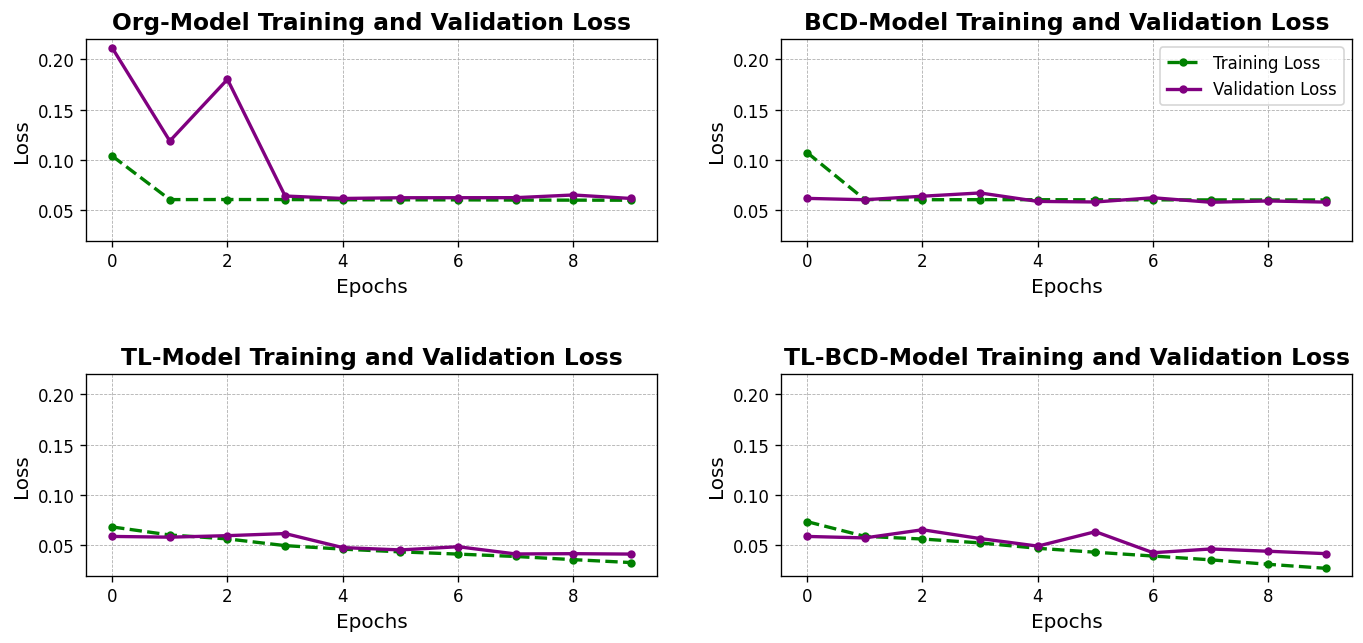

In [25]:
# Initialize lists to store data
train_loss_all = []
val_loss_all = []

# Load the data from JSON files
for path in local_path:
    with open(path, 'r') as infile:
        data = json.load(infile)
        train_loss_all.append(data['train_loss'])
        val_loss_all.append(data['val_loss'])

# Create a plot for each model's training and validation loss
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=120)
axes = axes.flatten()

# Assign model names for the titles
model_names = ['Org-Model', 'BCD-Model', 'TL-Model', 'TL-BCD-Model']

# Set a universal lower limit for y-axis
lower_limit = 0.02
train_color = 'green'
val_color = 'purple'

# Iterate over each model's data to plot
for i in range(4):
    axes[i].plot(train_loss_all[i], '-o', color=train_color, linestyle='--', label='Training Loss', linewidth=2, markersize=4)
    axes[i].plot(val_loss_all[i], '-o', color=val_color, label='Validation Loss', linewidth=2, markersize=4)
    axes[i].set_title(f'{model_names[i]} Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epochs', fontsize=12)
    axes[i].set_ylabel('Loss', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    if i ==1:
        axes[i].legend(fontsize=10)
    axes[i].set_ylim(0.02, 0.22)
    #axes[i].set_ylim(0.02, 0.12)

# Swap the positions of the TL-Model and TL-BCD-Model in the plot layout
axes[2], axes[3] = axes[3], axes[2]

plt.tight_layout(pad=3.0)
plt.show()

<ipython-input-18-a795916e43a5>:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(train_acc_all[i], '-o', color=train_color, linestyle='--', label='Training Acc', linewidth=2, markersize=4)


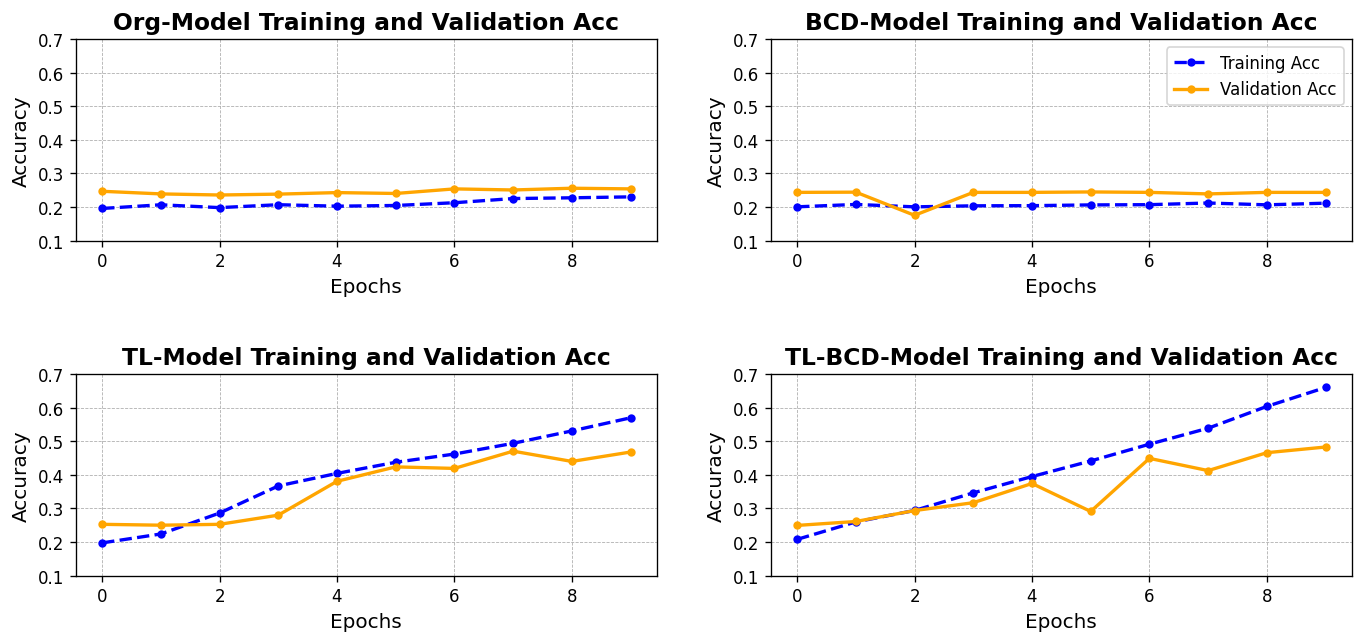

In [18]:
# Initialize lists to store data
train_acc_all = []
val_acc_all = []

# Load the data from JSON files
for path in local_path:
    with open(path, 'r') as infile:
        data = json.load(infile)
        train_acc_all.append(data['train_acc'])
        val_acc_all.append(data['val_acc'])

# Create a plot for each model's training and validation loss
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=120)
axes = axes.flatten()

# Assign model names for the titles
model_names = ['Org-Model', 'BCD-Model', 'TL-Model', 'TL-BCD-Model']

# Set a universal lower limit for y-axis
lower_limit = 0.02
train_color = 'blue'
val_color = 'orange'

# Iterate over each model's data to plot
for i in range(4):
    axes[i].plot(train_acc_all[i], '-o', color=train_color, linestyle='--', label='Training Acc', linewidth=2, markersize=4)
    axes[i].plot(val_acc_all[i], '-o', color=val_color, label='Validation Acc', linewidth=2, markersize=4)
    axes[i].set_title(f'{model_names[i]} Training and Validation Acc', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epochs', fontsize=12)
    axes[i].set_ylabel('Accuracy', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    if i ==1:
        axes[i].legend(fontsize=10)
    axes[i].set_ylim(0.1, 0.7)

# Swap the positions of the TL-Model and TL-BCD-Model in the plot layout
axes[2], axes[3] = axes[3], axes[2]

plt.tight_layout(pad=3.0)
plt.show()

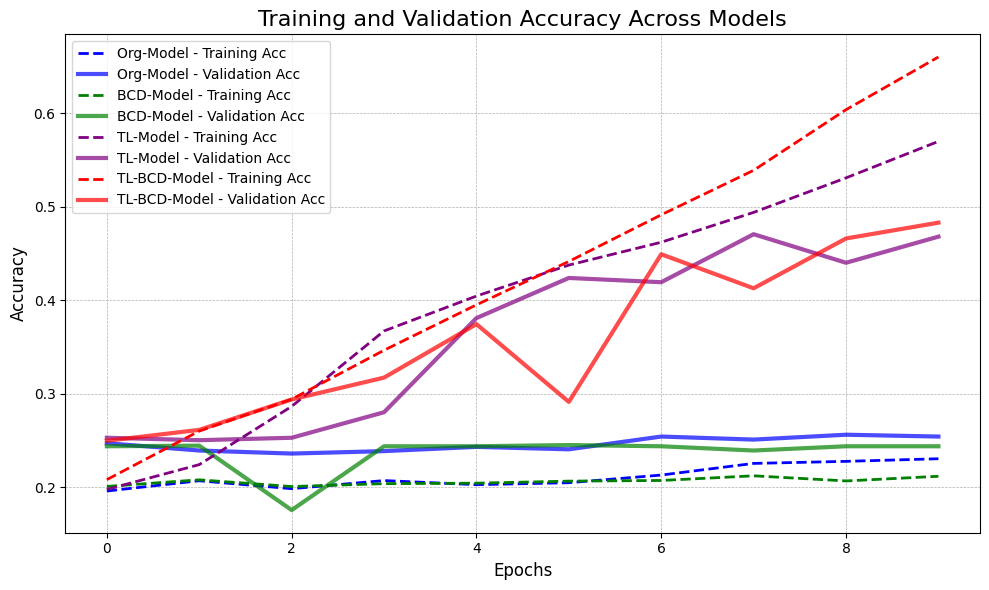

In [44]:
# Mock accuracy data
epochs = np.arange(10)
org_train_acc = train_acc_all[0]
org_val_acc = val_acc_all[0]
bcd_train_acc = train_acc_all[1]
bcd_val_acc = val_acc_all[1]
tl_train_acc = train_acc_all[2]
tl_val_acc = val_acc_all[2]
tl_bcd_train_acc = train_acc_all[3]
tl_bcd_val_acc = val_acc_all[3]

# Plot settings
colors = ['blue', 'green', 'purple', 'red']
labels = ['Org-Model', 'BCD-Model', 'TL-Model', 'TL-BCD-Model']
plt.figure(figsize=(10, 6))

# Create a Line2D object for each model's training and validation accuracy
for i, (train_acc, val_acc) in enumerate(zip(
    [org_train_acc, bcd_train_acc, tl_train_acc, tl_bcd_train_acc],
    [org_val_acc, bcd_val_acc, tl_val_acc, tl_bcd_val_acc])):

    plt.plot(epochs, train_acc, linewidth=2, linestyle='--', color=colors[i], label=f'{labels[i]} - Training Acc')
    plt.plot(epochs, val_acc, linewidth=3, color=colors[i], label=f'{labels[i]} - Validation Acc', alpha=0.7)

# Add legend to the plot with custom handles
plt.legend(loc='upper left', fontsize=10)

# Set titles and labels
plt.title('Training and Validation Accuracy Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

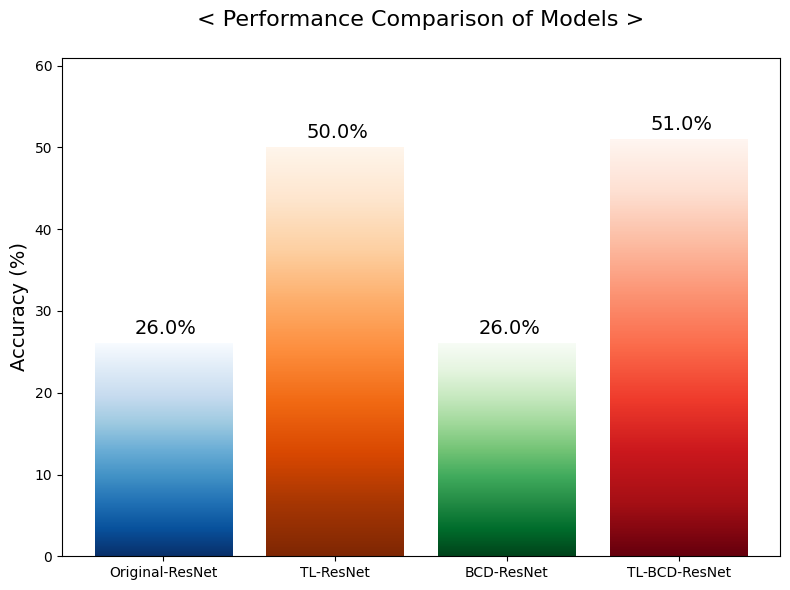

In [ ]:
def gradientbars(bars, cmap_list):
    # cmap 가중치 설정
    grad = np.atleast_2d(np.linspace(0,1,256)).T
    # 플롯 영역 재설정
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    # 각 막대에 색 입히기
    max = 0
    for i, bar in enumerate(bars):
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", cmap=cmap_list[i])

        plt.text(x+w/2.0+0.015, h+0.7, "{}%".format(h), fontsize=14, ha='center', va='bottom')

# 저장된 모델 전체 불러오기
org_net = torch.load("/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/Org-Model.pt", map_location='cuda')
org_net.eval()
trans_net = torch.load("/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-Model.pt", map_location='cuda')
trans_net.eval()
bcd_net = torch.load("/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/BCD-Model.pt", map_location='cuda')
bcd_net.eval()
trans_bcd_net = torch.load("/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-BCD-Model.pt", map_location='cuda')
trans_bcd_net.eval()

org_test_acc = test(net=org_net)
trans_test_acc = test(net=trans_net)
bcd_test_acc = test(net=bcd_net)
trans_bcd_test_acc = test(net=trans_bcd_net)

# 데이터 프레임 생성
df = pd.DataFrame({
    'Model': ['Original-ResNet', 'TL-ResNet', 'BCD-ResNet', 'TL-BCD-ResNet'],
    'Accuracy': [org_test_acc * 100, trans_test_acc * 100, bcd_test_acc * 100, trans_bcd_test_acc * 100]
})

# 색상 맵 리스트
cmap_color = ['Blues', 'Oranges', 'Greens', 'Reds']

# 막대 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(df.Model, df.Accuracy, color='none')

# 그라디언트 적용
gradientbars(bars, cmap_color)

# 제목 및 레이블 설정
plt.title("< Performance Comparison of Models >\n", fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, max(df.Accuracy) + 10)  # y축 범위 설정
plt.xticks(rotation=0)  # x축 레이블 회전
plt.tight_layout()  # 그래프 레이아웃 조정

# 그래프 표시
plt.show()

#### <b> 11. 실제 연예인 이미지 테스트 </b>

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = Image.open(image_path)
        channels = len(img.getbands())
        if channels == 4:
            img = img.convert("RGB")  # 알파 채널을 제외하고 RGB로 변환
        if self.transform:
            img = self.transform(img)
        return img

def real_img_test(net, loader):
    net.eval()
    pred_list = []
    for i, batch in enumerate(loader):
        imgs = batch
        imgs = imgs.cuda()
        with torch.no_grad():
            outputs = net(imgs)
            _, preds = torch.max(outputs, 1)
        pred_list.append(preds.item())
    return pred_list

label_to_age = {
    0: "Kids \n (0~6 years old)",
    1: "Young Adults \n (7~12 years old)",
    2: "Young Adults \n (13~19 years old)",
    3: "Young Adults \n (20~30 years old)",
    4: "Middle-aged Adults \n (31-45 years old)",
    5: "Middle-aged Adults \n (46-55 years old)",
    6: "Old Adults \n (56-66 years old)",
    7: "Old Adults \n (67-80 years old)"
}

# 이미지와 라벨 출력을 위한 함수 정의
def plot_images_with_labels(image_paths, names, pred_ages):
    num_images = len(image_paths)
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    plt.subplots_adjust(hspace=0.45)

    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        label = pred_ages[i]

        row = i // 4
        col = i % 4
        axs[row, col].imshow(image)
        axs[row, col].set_title(f"{label}", fontsize=10)
        axs[row, col].axis('off')

        label_x = image.size[0] / 2  # 이미지의 가로 중앙으로 텍스트를 이동시킵니다.
        label_y = image.size[1]  # 이미지의 아래에 텍스트를 표시합니다.
        axs[row, col].text(label_x, label_y+20, names[i], fontsize=10, ha='center', va='top')  # 이미지 밑에 라벨을 추가합니다.

    plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/TL-BCD-Model.pt" # 모델 파일 경로

image_paths = ["/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img1.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img2.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img3.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img4.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img5.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img6.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img7.png",
               "/content/drive/MyDrive/Colab Notebooks/Github_Repository/TL-ResNet/img8.png"]

names = ["[ Chu Sarang ]", "[ Jang Wonyoung ]", "[ Me ]\n(Baek Seungho)", "[ Swings ]", "[ Lee Jungjae ]", "[ Ryu Seungryong ]", "[ Na Moonhee ]", "[ Kim Youngok ]"]

real_test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True

real_dataset = CustomDataset(image_paths, real_test_transform)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=1, shuffle=False)
trans_net = torch.load(model_path)

pred_list = real_img_test(net=trans_net, loader=real_dataloader)
pred_ages = [label_to_age[pred] for pred in pred_list]

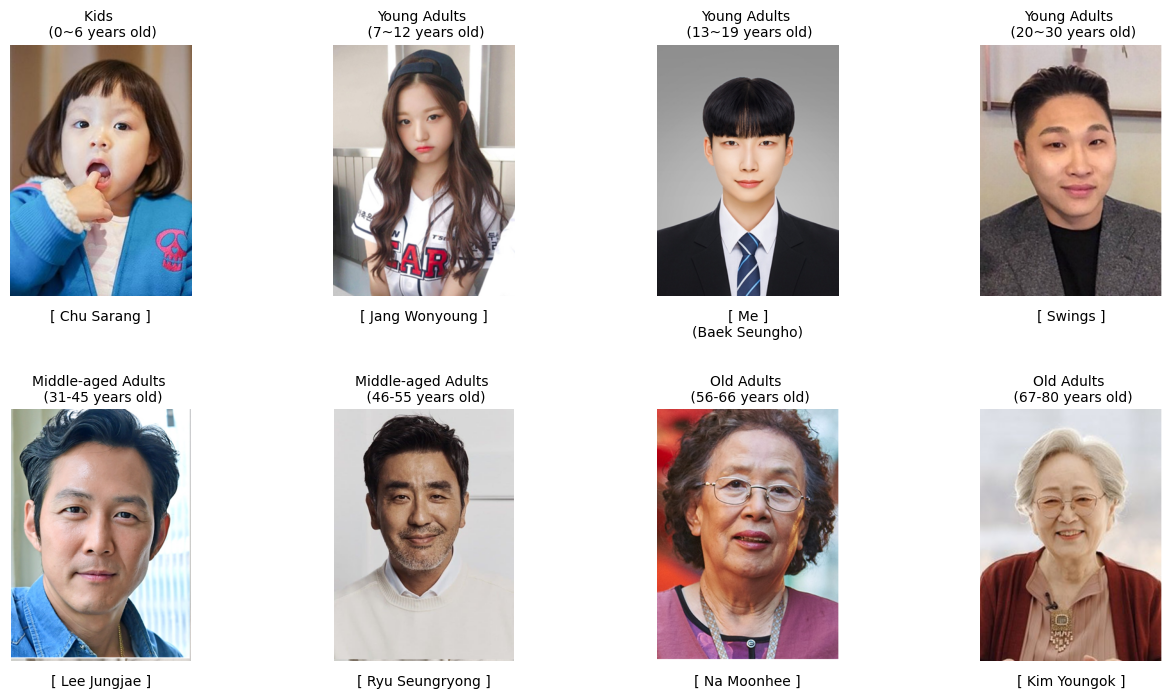

In [ ]:
# 이미지와 라벨을 그래프에 출력
plot_images_with_labels(image_paths ,names, pred_ages)